# Estimation and Anamoly Detection

This is an advanced topic ... 

This notebook provides what you will need to implement one meaans for controller diagnositics.

![](../figures/FeedbackControlDiagram2.png)

In the context of control, the control variable (CV) is heater temperature, the measured process variable (PV) is the sensor temperature, and we haven't yet established the relationship between them.

## State-Space Model

The same model can be written in a **state-space** matrix/vector format:

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

where

$$x = \begin{bmatrix} T_{H,1} \\ T_{S,1} \end{bmatrix}
\qquad
u = \begin{bmatrix} u_1 \end{bmatrix}
\qquad
d = \begin{bmatrix} T_{amb} \end{bmatrix}
\qquad
y = \begin{bmatrix} T_{S,1} \end{bmatrix}$$

and

$$A = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} \end{bmatrix}
\qquad
B_u = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}
\qquad
B_d = \begin{bmatrix} \frac{U_a}{C_p^H} \\ 0 \end{bmatrix}
\qquad
C = \begin{bmatrix} 0 & 1 \end{bmatrix}$$

By common convention, in state-space models the vector $x$ contains all variables representing the **state** of the system. The input vector $u$ is reserved for all manipulated variables (MV's), and the input vector $d$ for all disturbance variables (DV's). The vector $y$ holds all measured process variables (PV's).

In [1]:
import numpy as np

# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor
Tamb = 21             # ambient room temperature

# state space model
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
Bu = np.array([[alpha*P1/CpH], [0]])     # single column
Bd = np.array([[Ua/CpH], [0]])           # single column
C = np.array([[0, 1]])                   # single row

u_initial = np.array([0])                # initial manipulable input
d_initial = [Tamb]                       # initial disturbance input
x_initial = np.array([Tamb, Tamb])       # initial steady state

### Prediction and Correction

Making the substitution $\hat{y} = C\hat{x}$, the observer equation becomes

\begin{align*}
\frac{d\hat{x}}{dt} & = \underbrace{A \hat{x} + B_u u + B_d \hat{d}}_{\text{prediction}} - \underbrace{L(\hat{y} - y)}_{\text{correction}}
\end{align*}

As before, we can try approximating the derivative with a first order difference formula over small intervals of time. One clever detail is to choose the start of the interval, time $t_{k-1}$, to evaluate the model prediction part of the obsever equation, and use the process measurement available at end of the interval, time $t_k$, to evaluate the correction term.

$$\frac{\hat{x}_{k} - \hat{x}_{k-1}}{t_k - t_{k-1}} = \underbrace{A \hat{x}_{k-1} + B_u u_{k-1} + B_d \hat{d}_{k-1}}_{\text{prediction at time $t_{k-1}$}} - \underbrace{L(\hat{y}_k - y_k)}_{\text{correction at time $t_k$}}$$

For this purpose we introduce some extra notation. We use $\hat{x}_{k-1}$ to represent the state estimate at time $t_{k-1}$ using all information up to time $t_{k-1}$. Given knowledge of the manipulated inputs $u_{k-1}$ and an estimate of the disturbances $\hat{d}_{k-1}$, we will use the model to create a predicted state $\hat{x}_k^{pred}$ for time $t_k$. A measurement is then taken at time $t_k$ which is used to produce a new estimate $\hat{x}_k$. 

At each time step $t_k$ there are two calculations to perform:

* **Model Prediction:** Use the model to update the state to the next time step, i.e., $\hat{x}_{k-1} \rightarrow \hat{x}_{k}^{pred}$ with the equation

\begin{align}
\hat{x}_k^{pred} & = \hat{x}_{k-1} + (t_k - t_{k-1}) ( A \hat{x}_{k-1} + B_u u_{k-1} + B_d \hat{d}_{k-1}) \\
\hat{y}_k^{pred} & = C \hat{x}_k^{pred}
\end{align}

* **Measurement Correction:** Use measurement $y_k$ to update $\hat{x}_{k}^{pred} \rightarrow \hat{x}_{k}$ with the equation

$$\hat{x}_{k} = \hat{x}_{k}^{pred} - (t_k - t_{k-1})L (\hat{y}_{k}^{pred} - y_k)$$ 

While the notation may be a little daunting, the underlying concepts are quite straightforward. At each time step we have two calculations to perform. First, use all available information to predict the current state using the process model. Second, when a measurement becomes available, compare the measure to the model prediction and apply an appropriate correction to the state estimate. 

Let's see how this works in practice. The next cell introduces `tclab_observer`, a Python generator that creates instances of observers using the two-state model.

In [2]:
def tclab_observer(L, x_initial=[Tamb, Tamb]):
    # initialize variables
    t_now = 0
    x_now = x_initial
    d = d_initial                         # estimate of unmeasured disturbance
    y_err = None
    
    while True:
        # yield current state, get MV for next period
        t_next, Q, T_measured = yield x_now, y_err
        u = np.array([Q])
        d = np.array([Tamb])
        y = np.array([T_measured])
        
        # model prediction
        x_predict = x_now + (t_next - t_now)*(np.dot(A, x_now) + np.dot(Bu, u) + np.dot(Bd, d))
        y_predict = np.dot(C, x_predict)
        
        # measurement correction
        y_err = y_predict - y
        x_correct = x_predict - (t_next - t_now)*np.dot(L, y_err)
        
        # update time and state
        t_now = t_next
        x_now = x_correct

## Testing

The first experiment is to test if the observer can converge to the measured temperature. We will start with a very bad initial estimate.

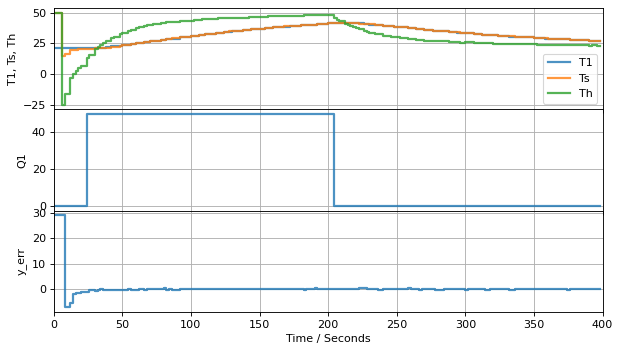

TCLab Model disconnected successfully.


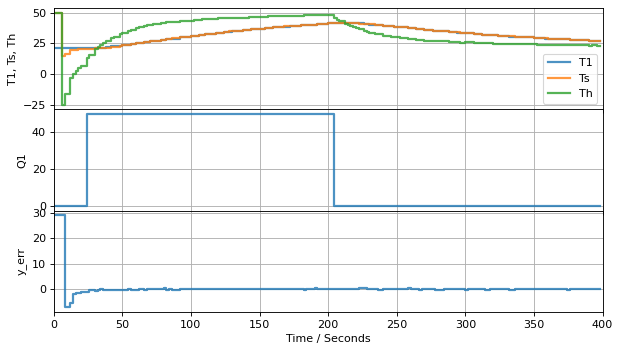

In [3]:
%matplotlib inline

from tclab import setup, Historian, Plotter, clock

# input
def u1(t):
    return 50 if 20 <= t <= 200 else 0

def experiment(observer, u1, t_final=400, t_step=2):
    # execute the event loop
    TCLab = setup(connected=False, speedup=20)
    with TCLab() as lab:
        sources = [('T1', lambda: lab.T1), ('Q1', lab.Q1),
                   ('Th', lambda: Th), ('Ts', lambda: Ts), 
                   ('y_err', lambda: y_err)]
        h = Historian(sources)
        p = Plotter(h, t_final, layout=[('T1','Ts', 'Th'), ['Q1'], ['y_err']])

        # initial input
        U1 = u1(0)
        lab.Q1(U1)
        next(observer)

        for t in clock(t_final, t_step):
            # get new measurement
            T1 = lab.T1
            x, y_err = observer.send([t, U1, lab.T1])

            # unpack state for historian
            Th, Ts = x
            p.update(t)

            # set input for next period
            U1 = u1(t)
            lab.Q1(U1)
            
    return h

# create observer/estimator instance
L = np.array([[0.4], [0.2]])
experiment(tclab_observer(L, x_initial=[50, 50]), u1)

<hr>

**Study Question:**

<hr>

## Choosing L

As this example has made clear, we need a notation that distinguishes the actual state of the physical system from our best estimate of that state. We will use $\hat{x}$ to denote our best estimate of $x$, and use $\hat{y}$ to denote the measurement that would result from $\hat{x}$. We can write two systems of equations corresponding to the dynamics of the actual process and to a model of the process.

* **Process**
\begin{align*}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align*}

* **Prediction Model**
\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B_u u + B_d \hat{d}\\
\hat{y} & = C \hat{x}
\end{align*}

We have made a bold assumption that the equatons and coefficients in these systems are the same. Any differences are due to different values for the states $x$ and $\hat{x}$, and differences between unmeasured process disturbances $d$ and our estimate for those disturbances, $\hat{d}$.

As we learned from the example, the problem with using this formulation for the feedback control of unmeasured states is that we are neglecting available measurements. This is a obvious oversight. How can this be addressed?

A brilliant answer to this question was given by David Luenberger in the early 1960's while a graduate student at Stanford University. The answer was to modify the second system of equations to include a corrective action due to differences between actual process measurements and predictions of what those measurments should be.

* **Observer**
\begin{align*}
\frac{d\hat{x}}{dt} & = \underbrace{A \hat{x} + B_u u + B_d \hat{d}}_{\text{prediction}} - \underbrace{L(\hat{y} - y)}_{\text{correction}}\\
\hat{y} & = C \hat{x}
\end{align*}

The idea is that if predicted measurements $\hat{y}$ are different from the actual measurements $y$, then corrective action will be imposed to modify the state estimates. In a sense, this is imposing feedback control on our process model to cause the model states to track the actual process states. We will need find values for a matrrix $L$ (after Luenberger?) to make this work.

Taking the difference between predicted and actual measurements, we find

\begin{align*}
\hat{y} - y & = C \hat{x} - C x \\
& = C\underbrace{(\hat{x} - x)}_e
\end{align*}

where $e = \hat{x} - x$ is error in our prediction of the state. Subtracting the new model equations from the process model, we get an expression for the dynamics of the model error $e = \hat{x} - x$

\begin{align*}
\frac{de}{dt} & = \frac{d\hat{x}}{dt} - \frac{dx}{dt} \\
\\
\frac{de}{dt} & = (A\hat{x} + B_u u + B_d \hat{d}) - (Ax + B_u u B_d d + L(C\hat{x} - C x)) \\
\\
\frac{de}{dt} & = (A - LC)(\hat{x} - x) + B_d(\hat{d} - d) \\
\\
\implies \frac{de}{dt} & = (A - LC) e + B_d(\hat{d} - d) 
\end{align*}

The choice of $L$ determines observer performance. What we seek is a matrix $L$ such that $A - LC$ results in error $e$ that quickly decays to zero.

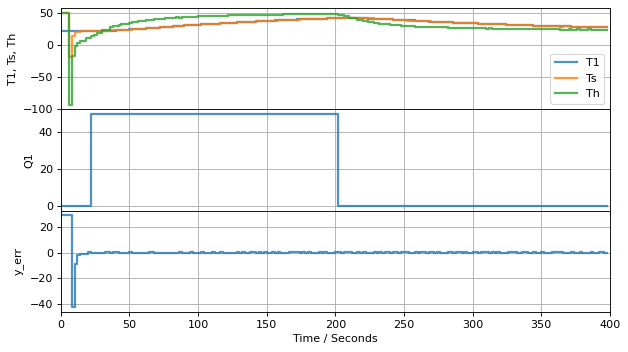

TCLab Model disconnected successfully.


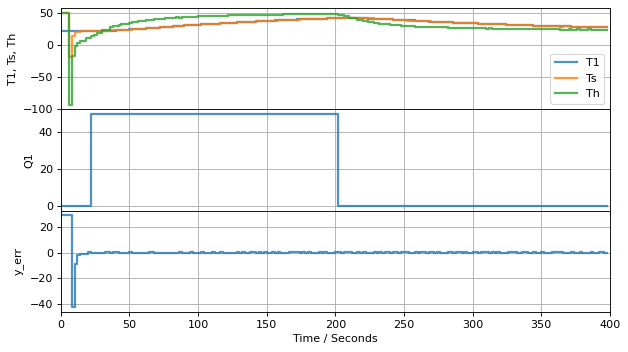

In [4]:
# create observer/estimator instance
L = np.array([[0.4], [0.2]])
experiment(tclab_observer(2*L, x_initial=[50, 50]), u1)

## Eigenvalues

Given a system

$$\frac{dx}{dt} = A x$$

1. An eigenvalue $\lambda_i$ and eigenvector $u_i$ satisfy a relationship

$$A u_j = \lambda_j u_j$$

2. Complex eigenvalues of real matrices come in complex conjugate pairs determine can be written
 
$$\lambda_{j,j+1} = \sigma \pm i \omega$$
 
3. Each eigenvalue corresponds to a 'mode'
 
    * Real eigenvalues 
     
    $$e^{\sigma t}$$
     
    * Each pair of complex conjugate eigenvalues corresponds to two modes
     
    $$e^{\sigma t}\sin(\omega t)$$
     
    $$e^{\sigma t}\cos{\omega t}$$
     
3. The system is asympototically stable if and only if the eigenvalues of $A$ have negative real part.


In [5]:
eigenvalues, eigenvectors = np.linalg.eig(A)
print 

for val, vec in zip(eigenvalues, eigenvectors.T):
    print(f"eigenvalue = {val : 8.5f}")
    print(f"time constant = {-1/val : 5.2f} seconds")
    print(f"eigenvector = {vec}")
    print(f"     A u = {np.dot(A, vec)}")
    print(f"lambda u = {val*vec}")
    print()

eigenvalue = -0.03643
time constant =  27.45 seconds
eigenvector = [-0.91681931  0.39930233]
     A u = [ 0.03339978 -0.01454661]
lambda u = [ 0.03339978 -0.01454661]

eigenvalue = -0.00690
time constant =  145.03 seconds
eigenvector = [-0.35205837 -0.93597805]
     A u = [0.00242755 0.00645385]
lambda u = [0.00242755 0.00645385]



Application to state space model

In [6]:
%matplotlib inline
import matplotlib.gridspec as gridspec

u_ss = np.array([50])                # constant manipulable input
d_ss = [Tamb]                       # constanat disturbance input
x_initial = np.array([Tamb, Tamb])  # initial steady state

def tctlab_phase_plane(ic, u_ss, d_ss):
    
    def deriv(t, x):
        return np.dot(A, x) + np.dot(Bu, u_ss) + np.dot(Bd, d_ss)

    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(2, 3)
    ax = fig.add_subplot(gs[:, 0])

    bx = fig.add_subplot(gs[0, 1:])
    cx = fig.add_subplot(gs[1, 1:])

    for ic in x_ic:
        soln = solve_ivp(deriv, [0, 500, 0], ic, t_eval=np.linspace(0, 500, 501))
        t = soln.t
        x = soln.y
        ax.plot(x[0], x[1], 'b', label="trajectory")
        ax.plot(ic[0], ic[1], 'bo', label="initial condition")
        
        bx.plot(t, x[0])
        cx.plot(t, x[1])
    ax.set_xlabel('Th: heater temp / deg C')
    ax.set_ylabel('Ts: sensor temp / deg C')
    ax.axis('equal')
    ax.axis('square')
    ax.grid(True)
    ax.plot(x_ss[0], x_ss[1], 'r.', ms=20, label="steady state")

    eigenvaalues, eigenmatrix = np.linalg.eig(A)
    for val, vec in zip(eigenvalues, eigenmatrix.T):
        r = 20
        ax.plot([x_ss[0], x_ss[0] + r*vec[0]], [x_ss[1], x_ss[1] + r*vec[1]], 'r--', lw=2)
        ax.plot([x_ss[0], x_ss[0] - r*vec[0]], [x_ss[1], x_ss[1] - r*vec[1]], 'r--', lw=2)
    ax.set_xlim(Tamb-2, 90)
    ax.set_ylim(Tamb-2, 90)

x_ss = np.linalg.solve(A, -(np.dot(Bd, d_ss) + np.dot(Bu, u_ss)))
x_ic = [[x_ss[0] + 25*np.cos(a), x_ss[1] + 30*np.sin(a)] for a in np.linspace(0, 2*np.pi, 1)]

tclab_phase_plane(x_ic, [50], [Tamb])

#def tclab_sim(x_ics, [50], [21]):
#    pass
    #_, bx = plt.subplots(2, 1)
        #bx[0].plot(t, x[0])
        #bx[0].set_title('heater temp')
        #bx[0].grid(True)
        #bx[1].plot(t, x[1])
        #bx[1].set_title('sensor temp')
        #bx[1].grid(True)
        #plt.tight_layout()


NameError: name 'tclab_phase_plane' is not defined

In [ ]:
from scipy.signal import place_poles

evals, evecs = np.linalg.eig(A)
results = place_poles(A.T, C.T, 3*evals)
print(3*evals, results.computed_poles)
L = results.gain_matrix.T
print(L)

In [ ]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(h.logdict["Time"], h.logdict["Ts"], h.logdict["Time"], h.logdict["T1"])
ax[1].plot(h.logdict["Time"], np.array(h.logdict["Ts"]) - np.array(h.logdict["T1"]))

**Study Question:** Rerun the estimator simulation using:

* Change parameter value
* Change in d
* Change sensor offset
* 